In [447]:
import pandas as pd
import random
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix

import statsmodels.api as sm


from scipy import stats


In [448]:
random.seed(1)

df_emotion_and_LIWC = pd.read_csv("LIWC_and_emotions.csv")
pos = (df_emotion_and_LIWC[df_emotion_and_LIWC["flagged"]=="Y"])
neg= (df_emotion_and_LIWC[df_emotion_and_LIWC["flagged"]=="N"])
df_neg_only = neg.sample(n=len(pos))

df_emotion = pd.concat([df_neg_only, pos])


In [449]:
df_emotion.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16320 entries, 12968 to 16409
Data columns (total 27 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          16320 non-null  object 
 1   reviewID      16320 non-null  object 
 2   reviewerID    16320 non-null  object 
 3   review        16320 non-null  object 
 4   rating        16320 non-null  int64  
 5   flagged       16320 non-null  object 
 6   restaurantID  16320 non-null  object 
 7   WC            16320 non-null  int64  
 8   Analytic      16320 non-null  float64
 9   Clout         16320 non-null  float64
 10  Authentic     16320 non-null  float64
 11  Tone          16320 non-null  float64
 12  WPS           16320 non-null  float64
 13  Sixltr        16320 non-null  float64
 14  pronoun       16320 non-null  float64
 15  ppron         16320 non-null  float64
 16  i             16320 non-null  float64
 17  we            16320 non-null  float64
 18  you           16320 no

## Replicating LIWC PACIS paper: T-tests

Features:

**LIWC**
- WC
- Analytical
- Tone
- Authentic
- Clout

**Other**
- Readability (Coleman Liau index)
- Rating extremity (the absolute difference of review star rating and existing business star rating)
- Days (days from the reviews date to the data collection date)

**To try**
- Days (days from first review to this review)
- Emotion extremity
- Neg/pos rating


In [450]:
#df_paired = df_emotion.drop(columns=["date","reviewID","reviewerID","review","rating","restaurantID","pronoun","i", "we", "you", "shehe", "they"])
#df_paired = df_emotion.drop(columns=["date","reviewID","reviewerID","review","restaurantID"])
res_ids = tuple(df_emotion["restaurantID"])


In [451]:
import sqlite3

def connect_db(db_file):
    conn = None
    try:
        conn = sqlite3.connect(db_file)
    except Error as e:
        print(e)

    return conn

conn = connect_db("/Users/jamesfyfe/summer vac misc/yelpResData.db")

cur = conn.cursor()
query = "SELECT * FROM restaurant WHERE restaurantID in {}".format(res_ids)
query_dist = "SELECT count(*),count(distinct restaurantID) FROM restaurant"

cur.execute(query_dist)
rows_dist = cur.fetchall()
print(rows_dist) # checking for duplicates to see if maybe same record with diff ratings exists for a restaurant

# get restaurants matching our balanced reviews dataset
cur.execute(query)
rows = cur.fetchall()

[(242652, 242652)]


In [452]:
#for i,row in df_emotion.iterrows():
 #   df_emotion.at[i,"ResRating"] = rows[[rows[0]]==df_emotion.at[i,"restaurantID"]][4]
 
for i in range (0,len(rows)):
    df_emotion.at[df_emotion["restaurantID"]==rows[i][0],"ResRating"]= rows[i][4]

    
#df_emotion["ResRating"] = rows[[rows[0]]==df_emotion["restaurantID"]][4]



In [453]:
df_emotion["RatingDiff"] = np.abs(df_emotion["rating"]-df_emotion["ResRating"])
df_emotion

,date,reviewID,reviewerID,review,rating,flagged,restaurantID,WC,Analytic,Clout,...,shehe,they,ipron,sadness,anger,disgust,joy,fear,ResRating,RatingDiff
12968,7/9/2012,qpRe9Tp7eoqiBORL2wsCHg,nPgAnPH3XOZPUYM8HHEPBQ,Went for dinner. Staff was great. We had the c...,5,N,dKcO9OQ44RPRlkWe-vToFA,19,64.39,94.27,...,0.00,0.00,0.00,0.024373,0.022666,0.073711,0.792669,0.011401,4.0,1.0
12904,7/30/2011,db9iC0TQ,O6HjMGAiWX2zIr2McjfQ4A,This is always on my To Eat places when I'm in...,5,N,8d_DiHWB-pjBVW3a7D8EWg,142,33.89,73.69,...,0.70,1.41,4.93,0.088836,0.086003,0.068219,0.704147,0.043417,4.0,1.0
15752,4/12/2011,KhrCDaR2dChExluveEkP2g,4A1lJvjAffIwuVAeT_pFXg,Violet Hour was pretty good. I went with the h...,4,N,oEFJ29zAQaCNnQzebHQvpg,161,61.75,33.19,...,0.00,0.00,4.97,0.197084,0.099322,0.062165,0.676664,0.096470,4.0,0.0
513,8/27/2012,piQelOxdi9BgqHaEd92Ylg,KOBQK4kjVP-k5GT_wTmgfA,Granted my review and rating is completely bia...,3,N,JMa9cTNQA5mm4GbR2W8Oiw,210,68.29,53.81,...,0.00,0.48,3.81,0.146591,0.090492,0.109280,0.696552,0.064400,4.0,1.0
9431,2/12/2007,WIo1EGGa9ZSPjgwUM2Mz7g,2Bso1ZL-nFEoaGyhjPVAAA,eh. it was ok. i had heard nothing but amazing...,3,N,6PQTqW9j-sriDBQyQCJbjw,166,20.41,4.04,...,0.00,0.00,7.83,0.605067,0.129968,0.150193,0.489318,0.098873,4.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16403,11/19/2010,BKXex6CFqUeQetnTvtibKg,oNFaRkiq17cfFc2q111nug,First time visiting and we were being treated ...,4,Y,8d_DiHWB-pjBVW3a7D8EWg,95,52.71,41.67,...,1.05,0.00,5.26,0.577808,0.085841,0.070605,0.688406,0.059792,4.0,0.0
16404,3/1/2011,ukeqNQkw3rlFaQuwz8p_xw,lH913sX4Mr7e8v2LMEAyJA,"Great food, great service, and great atmospher...",5,Y,6gZTET0y7ARZMrbJRmI2mw,79,72.31,84.44,...,0.00,0.00,2.53,0.185005,0.071661,0.025063,0.735421,0.006916,3.5,1.5
16405,5/4/2010,vwBJwQLYGumSvpe_cxxY1A,FtiocxJuP_RebtIqotRrpg,This place was incredible.. EXCELLENT service....,5,Y,_UJ3KqtHIHjExbAg-iIGUA,41,3.52,83.54,...,0.00,0.00,9.76,0.473392,0.053337,0.057628,0.708207,0.092933,4.0,1.0
16407,5/10/2010,7aAqvADp2FlbvY3OJ3I9OQ,BgPMUkC8LlLl1fc17RvUog,"So, it's nearly impossible for me to write a c...",3,Y,n-mj6IJkWyCu4BuD2dvm0A,176,56.25,41.03,...,1.14,0.00,5.68,0.585019,0.593745,0.497132,0.545144,0.118086,4.0,1.0


In [ ]:
# calculating Readability (Coleman Liau index)
df_emotion["Sentences"] = df_emotion["WC"]/df_emotion["WPS"]

for i,row in df_emotion.iterrows():
    df_emotion.at[i,"Letters"] = sum(c.isalpha() for c in df_emotion.at[i,"review"])
    #len(df_emotion.at[i,"review"])
   # print(df_emotion.at[i,"review"])

df_emotion["Readability"] = (df_emotion["Letters"]*100/df_emotion["WC"]*0.0588)-(0.296*df_emotion["Sentences"]*100/df_emotion["WC"])-15.8
df_emotion.rename(columns={'rating': 'Rating'}, inplace=True)


In [ ]:
stats_lst = []
no_emotions_lst = []

feature_lst = [ # includes emotions
 'WC',
 'Analytic',
 'Tone',
 'Clout',
 'Authentic',
 'joy',
 'anger',
 'sadness',
 'disgust',
 'fear',
 'Readability',
 'Rating',
 'RatingDiff',
 'ipron', #impersonal pronouns
    'i',
    'we',
    'you',
 'shehe',
 'they']

################ without emotions ##############
linguist_feature_lst = [ # the Top Reviewer paper features only
 'WC',
 'Analytic',
 'Tone',
 'Clout',
 'Authentic',
 'Readability',
 'Rating',
 'RatingDiff']


for feature in feature_lst:
    mean_real = np.mean(df_emotion[df_emotion["flagged"]=="N"][feature])
    mean_fake = np.mean(df_emotion[df_emotion["flagged"]=="Y"][feature])
    med_real = np.median(df_emotion[df_emotion["flagged"]=="N"][feature])
    med_fake = np.median(df_emotion[df_emotion["flagged"]=="Y"][feature])
    stdev_real = np.std(df_emotion[df_emotion["flagged"]=="N"][feature])
    stdev_fake = np.std(df_emotion[df_emotion["flagged"]=="Y"][feature])
    stats_lst.append([feature,"real",mean_real,med_real,stdev_real])
    stats_lst.append([feature,"fake",mean_fake,med_fake,stdev_fake])

    


In [ ]:
paired_stats = pd.DataFrame(stats_lst,columns=["Feature","Review","Mean","Median","Stdev"])

################ without emotions ##############
paired_stats_original_paper = paired_stats[paired_stats["Feature"].isin(linguist_feature_lst)]

In [312]:
paired_stats

################ without emotions ##############
#paired_stats_original_paper  

,Feature,Review,Mean,Median,Stdev
0,WC,real,146.275490,114.000000,121.077323
1,WC,fake,101.407475,71.000000,99.644241
2,Analytic,real,57.055240,58.730000,23.501866
3,Analytic,fake,56.974985,58.680000,25.955518
4,Tone,real,81.763053,94.470000,24.982012
5,Tone,fake,80.651121,97.580000,28.672983
6,Clout,real,47.620385,47.095000,23.456895
7,Clout,fake,51.715174,50.000000,25.854837
8,Authentic,real,48.138125,47.070000,27.909566
9,Authentic,fake,47.877473,47.070000,30.546632


In [313]:
t_test_df = []
for feature in feature_lst:
    t_test = stats.ttest_ind(df_emotion[df_emotion["flagged"]=="N"][feature],df_emotion[df_emotion["flagged"]=="Y"][feature])
    t_stat = round(t_test[0],3)
    p_val = round(t_test[1],3)
    t_test_df.append([feature,t_stat,p_val])

pd.DataFrame(t_test_df, columns=["Feature","t-stat","p-value"])

,Feature,t-stat,p-value
0,WC,25.846,0.000
1,Analytic,0.207,0.836
2,Tone,2.641,0.008
3,Clout,-10.595,0.000
4,Authentic,0.569,0.569
5,joy,-1.757,0.079
6,anger,4.165,0.000
7,sadness,15.713,0.000
8,disgust,4.633,0.000
9,fear,10.175,0.000


## Regression

In [446]:
########## MOdel as in the tope reviewer paper #############
df_reg_emotion = df_emotion[["WC","Readability","RatingDiff","Analytic","Tone","Authentic","Clout","flagged"]]

########## Full model #############
#df_reg_emotion = df_emotion.drop(columns=["date","reviewID","reviewerID","review","Rating","restaurantID","ResRating","Sixltr","Sentences","Letters","pronoun","ppron"])



In [443]:
from sklearn.preprocessing import StandardScaler

le_emotion = preprocessing.LabelEncoder()
df_reg_emotion["flagged"] = le_emotion.fit_transform(df_reg_emotion["flagged"])

X = df_reg_emotion.drop(columns=["flagged"])
X = sm.add_constant(X)
Y = df_reg_emotion["flagged"]

#scaler = StandardScaler()
#X = scaler.fit_transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 1, shuffle=True, stratify=Y)

model = sm.Logit(Y_train, X_train)
result = model.fit()

print("\nAccuracy: " + str(sum((result.predict(X_test) >= 0.5).astype(int) == Y_test)/len(Y_test)))
result.summary()



Optimization terminated successfully.
         Current function value: 0.644208
         Iterations 5

Accuracy: 0.6314338235294118


/Users/jamesfyfe/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                flagged   No. Observations:                13056
Model:                          Logit   Df Residuals:                    13052
Method:                           MLE   Df Model:                            3
Date:                Tue, 19 Jan 2021   Pseudo R-squ.:                 0.07060
Time:                        22:03:54   Log-Likelihood:                -8410.8
converged:                       True   LL-Null:                       -9049.7
Covariance Type:            nonrobust   LLR p-value:                9.150e-277
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3608      0.048     -7.461      0.000      -0.456      -0.266
WC            -0.0049      0.000    -25.106      0.000      -0.005      -0.005
RatingDiff     0.5602      0.024     22.882      0.000       0.512       0.608
Clout          0.0091      0.001     12.109      0.000       0.008       0.011
==============================================================================
"""

In [444]:
print(classification_report(Y_test, (result.predict(X_test) >= 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.63      0.62      0.63      1632
           1       0.63      0.64      0.64      1632

    accuracy                           0.63      3264
   macro avg       0.63      0.63      0.63      3264
weighted avg       0.63      0.63      0.63      3264



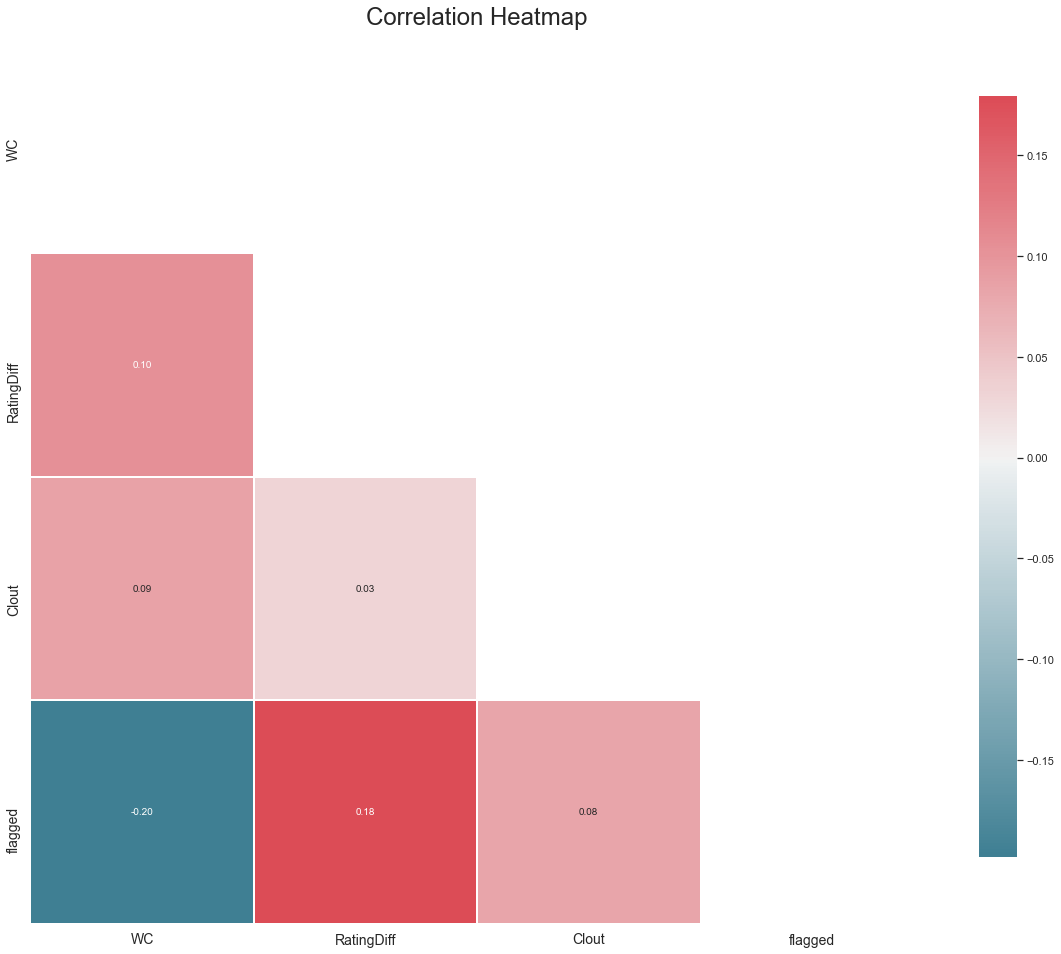

In [445]:
import seaborn as sns
import matplotlib.pyplot as plt

def heatmap(df_fs):
    sns.set(style="white")
    # Calculating Pearson's correlation coefficient of the subsetted data
    correlation = (pd.concat([df_fs.drop(columns=["flagged"]),df_fs["flagged"]], axis=1)).corr()
    mask = np.zeros_like(correlation, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    fig, ax = plt.subplots(figsize=(20,20))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(correlation, center=0, mask=mask,cmap=cmap,
                fmt='.2f', square=True, linewidths=.5, 
                annot=True, cbar_kws={"shrink": .70},  
                annot_kws={"size": 10})
    ax.set_title('Correlation Heatmap', fontsize = 24)
    ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 14)
    ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 14)

    
heatmap(df_reg_emotion)

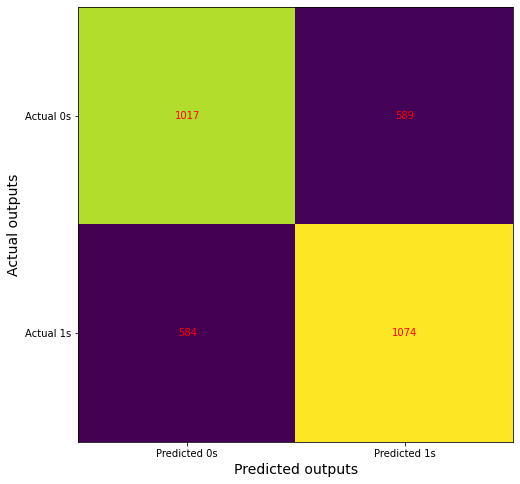

In [351]:
cm = confusion_matrix(Y_test, (result.predict(X_test) >= 0.5).astype(int))

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.set_xlabel('Predicted outputs', fontsize=14, color='black')
ax.set_ylabel('Actual outputs', fontsize=14, color='black')
ax.xaxis.set(ticks=(0,1),ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0,1),ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

## Random Forest

In [429]:
from sklearn.metrics import accuracy_score

#from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state = 1, n_estimators=1000)
#X = feature_selection(X_train,Y_train, 150)

rf_model.fit(X_train, Y_train)
rf_predictions = rf_model.predict(X_test)
acc = accuracy_score(rf_predictions,Y_test)
acc

0.6620710784313726